In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import pickle
import os

## Getting data from my SQL database

First I want to use Pandas to get some data from my MySQL database.

In [93]:
# format: engine = create_engine('mysql+pymysql://<user>:<password>@<host>[:<port>]/<dbname>')
db_user = os.environ.get('MYSQL_USER')
db_pass = os.environ.get('MYSQL_PASS')
db_host = os.environ.get('MYSQL_HOST')
engine = create_engine(f"mysql+pymysql://{db_user}:{db_pass}@{db_host}/subways")

In [97]:
df = pd.read_sql_query("""
    SELECT snapshotUnix, snapshotNYC, routeId, stationIdGTFS, direction, timeToArrival
    FROM traintimes 
    WHERE
        (snapshotNYC BETWEEN "2019-01-22" AND "2019-02-22") 
        AND routeId="1" 
        AND trainOrderLine=0 
    ORDER BY 
        direction, stationIdGTFS, snapshotNYC;
""", engine)

In [98]:
len(df)

3180360

In [99]:
# saving what we have so far as a feather file

df.to_feather('month_sample')

In [57]:
df = pd.read_feather('./tmp/month_sample')

## Data prep

First I add a `name` column to the data frame:

In [58]:
### using "zip" as described in the Fast.AI class, which Jeremy says is 300x faster
underscore="_"
result = []

for r,s,d in zip(df.routeId.values, df.stationIdGTFS.values, df.direction.values):
    result.append(r+underscore+s+underscore+d)
df['name'] = result

In [8]:
### This runs slower, but would do the same thing
# df['name']=df.apply(lambda row: f'{row.routeId}_{row.stationIdGTFS}_{row.direction}', axis=1)

In [59]:
# there it is ...
df.head(10)

snapshotUnix         snapshotNYC routeId stationIdGTFS direction  \
0    1548133274 2019-01-22 00:01:14       1           101         N   
1    1548133334 2019-01-22 00:02:14       1           101         N   
2    1548133394 2019-01-22 00:03:14       1           101         N   
3    1548133514 2019-01-22 00:05:14       1           101         N   
4    1548133574 2019-01-22 00:06:14       1           101         N   
5    1548133634 2019-01-22 00:07:14       1           101         N   
6    1548133694 2019-01-22 00:08:14       1           101         N   
7    1548133754 2019-01-22 00:09:14       1           101         N   
8    1548133814 2019-01-22 00:10:14       1           101         N   
9    1548133874 2019-01-22 00:11:14       1           101         N   

   timeToArrival     name  
0          358.0  1_101_N  
1          232.0  1_101_N  
2          187.0  1_101_N  
3           22.0  1_101_N  
4          -49.0  1_101_N  
5          654.0  1_101_N  
6          609.0  1_101_N  
7          557.0  1_101_N  
8          495.0  1_101_N  
9          457.0  1_101_N

## Removing duplicate data

I apparently have duplicate name-timestamps. Which is strange. Here's how I elimiate them.


In [60]:
# Looking to see where we have rows where 'snapshotNYC' and 'name' are the same. 
# Note that "keep=False" means ALL duplicated rows will return (they're be marked "True")
dupes = df[df.duplicated(['snapshotNYC','name'], keep=False)].sort_values(['snapshotNYC','name']) 
display_all(dupes)

snapshotUnix         snapshotNYC routeId stationIdGTFS direction  \
19116      1549364294 2019-02-05 05:58:14       1           101         N   
19117      1549364294 2019-02-05 05:58:14       1           101         N   
1609400    1549364294 2019-02-05 05:58:14       1           101         S   
1609401    1549364294 2019-02-05 05:58:14       1           101         S   
60987      1549364294 2019-02-05 05:58:14       1           103         N   
60988      1549364294 2019-02-05 05:58:14       1           103         N   
1651185    1549364294 2019-02-05 05:58:14       1           103         S   
1651186    1549364294 2019-02-05 05:58:14       1           103         S   
102858     1549364294 2019-02-05 05:58:14       1           104         N   
102859     1549364294 2019-02-05 05:58:14       1           104         N   
1692975    1549364294 2019-02-05 05:58:14       1           104         S   
1692976    1549364294 2019-02-05 05:58:14       1           104         S   
144729     1549364294 2019-02-05 05:58:14       1           106         N   
144730     1549364294 2019-02-05 05:58:14       1           106         N   
1734767    1549364294 2019-02-05 05:58:14       1           106         S   
1734768    1549364294 2019-02-05 05:58:14       1           106         S   
186600     1549364294 2019-02-05 05:58:14       1           107         N   
186601     1549364294 2019-02-05 05:58:14       1           107         N   
1776631    1549364294 2019-02-05 05:58:14       1           107         S   
1776632    1549364294 2019-02-05 05:58:14       1           107         S   
228471     1549364294 2019-02-05 05:58:14       1           108         N   
228472     1549364294 2019-02-05 05:58:14       1           108         N   
1818497    1549364294 2019-02-05 05:58:14       1           108         S   
1818498    1549364294 2019-02-05 05:58:14       1           108         S   
270342     1549364294 2019-02-05 05:58:14       1           109         N   
270343     1549364294 2019-02-05 05:58:14       1           109         N   
1860367    1549364294 2019-02-05 05:58:14       1           109         S   
1860368    1549364294 2019-02-05 05:58:14       1           109         S   
312213     1549364294 2019-02-05 05:58:14       1           110         N   
312214     1549364294 2019-02-05 05:58:14       1           110         N   
1902237    1549364294 2019-02-05 05:58:14       1           110         S   
1902238    1549364294 2019-02-05 05:58:14       1           110         S   
354084     1549364294 2019-02-05 05:58:14       1           111         N   
354085     1549364294 2019-02-05 05:58:14       1           111         N   
1944108    1549364294 2019-02-05 05:58:14       1           111         S   
1944109    1549364294 2019-02-05 05:58:14       1           111         S   
395955     1549364294 2019-02-05 05:58:14       1           112         N   
395956     1549364294 2019-02-05 05:58:14       1           112         N   
1985979    1549364294 2019-02-05 05:58:14       1           112         S   
1985980    1549364294 2019-02-05 05:58:14       1           112         S   
437826     1549364294 2019-02-05 05:58:14       1           113         N   
437827     1549364294 2019-02-05 05:58:14       1           113         N   
2027850    1549364294 2019-02-05 05:58:14       1           113         S   
2027851    1549364294 2019-02-05 05:58:14       1           113         S   
479697     1549364294 2019-02-05 05:58:14       1           114         N   
479698     1549364294 2019-02-05 05:58:14       1           114         N   
2069721    1549364294 2019-02-05 05:58:14       1           114         S   
2069722    1549364294 2019-02-05 05:58:14       1           114         S   
521568     1549364294 2019-02-05 05:58:14       1           115         N   
521569     1549364294 2019-02-05 05:58:14       1           115         N   
2111592    1549364294 2019-02-05 05:58:14       1           115         S   
21115

In [61]:
len(dupes) # counting all duplicated rows

608

Unclear why we have duplicate data, but eyeballing it shows that the timeToArrival is usually the same or nearly so. So picking the last reading in every case.

In [62]:
len(df)

3180360

In [63]:
df.drop_duplicates(['snapshotNYC','name'], keep='last', inplace=True) # keeping the last version of the dupes

In [64]:
len(df)

3180056

## Marking "in station" events

My operating theory here is that for a given route_station_direction (a train platform, really), that if the current time to next train is _greater_ than the last reading (usually a minute ago) then a train just left the station. So:



Ooooh: We can calculate the time since the train last left the station.

In [65]:
# df = pickle.load(open('saved_sample3.p', 'rb'))
df.sort_values(['name', 'snapshotUnix'], inplace=True)

In [66]:
## helpful function from the fast.ai class
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 1000): 
        display(df)

Initially, I used this method to iterate over all of the rows in the database -- doing it pretty quickly with the `zip()` function. But Quartz's Chris Saunders says his rule of thumb is "never iterate over rows," and instead use _column-based_ calculations available in Pandas. 

Here was my old code:

```python
# for this to work, we have to be sorted by the entry name and then by datetime
df.sort_values(['name', 'snapshotUnix'], inplace=True)

# establish initial settings
last_seconds_to_arrival = 0
last_name = ""
last_in_station_time = 1548133274   # <- eventually this could be stored in a db for next data check
left_station_array = []
gap = []

# run through all of the rows using zip, which is superfast
for name, seconds_to_arrival, snapshot_time in zip(df.name.values, df.timeToArrival.values, df.snapshotUnix.values):

    left_station = 0
    
    if name != last_name:
        # we've hit a new route/station/direction name
        # reset the 'last' values
        last_seconds_to_arrival = 0
        last_in_station_time = 1548133274
        last_name = name
        

    if seconds_to_arrival > last_seconds_to_arrival:
        # train must have just left the station
        # reset last in station to now
        left_station = 1
        last_in_station_time = snapshot_time
    
    # no matter what, calculate the time since the last time in the station
    seconds_since_in_station = (snapshot_time - last_in_station_time)
    
    # calculate the current gap and add it to the array
    gap.append(seconds_since_in_station + seconds_to_arrival)
    
    # calculate the current in_station and add it to the array
    left_station_array.append(left_station)
    
    # save the current time to arrival for next use
    last_seconds_to_arrival = seconds_to_arrival
    
df['left_station'] = left_station_array
df['gap'] = gap
```

In [67]:
# Here is my OMG cool column-based code by Chris Saunders
df.sort_values(['name', 'snapshotUnix'], inplace=True)

dfx = df[['name', 'timeToArrival', 'snapshotUnix','snapshotNYC']].copy() # copies just the columns we need
dfx['name_shift'] = dfx['name'].shift(1).fillna(method='bfill') # create new col to detect if we have a new station
dfx['new_station?'] = dfx['name'] != dfx['name_shift'] # do the new-station calculation

dfx['left_station'] = (dfx['timeToArrival'].shift(1) < dfx['timeToArrival']) | dfx['new_station?'] # is the previous wait < current wait
dfx.loc[0, 'left_station'] = True #set first value to True

dfx['snapshotUnix_'] = dfx.loc[dfx['left_station'], 'snapshotUnix'] # time-track column set to time left_station true
dfx['snapshotUnix_'] = dfx['snapshotUnix_'].fillna(method='ffill').astype(int) # does a fill-down to the next time
dfx['delta'] = dfx['snapshotUnix'] - dfx['snapshotUnix_']
dfx['gap'] = dfx['timeToArrival'] + dfx['delta']

In [68]:
display_all(dfx.head(100))

name  timeToArrival  snapshotUnix         snapshotNYC name_shift  \
0   1_101_N          358.0    1548133274 2019-01-22 00:01:14    1_101_N   
1   1_101_N          232.0    1548133334 2019-01-22 00:02:14    1_101_N   
2   1_101_N          187.0    1548133394 2019-01-22 00:03:14    1_101_N   
3   1_101_N           22.0    1548133514 2019-01-22 00:05:14    1_101_N   
4   1_101_N          -49.0    1548133574 2019-01-22 00:06:14    1_101_N   
5   1_101_N          654.0    1548133634 2019-01-22 00:07:14    1_101_N   
6   1_101_N          609.0    1548133694 2019-01-22 00:08:14    1_101_N   
7   1_101_N          557.0    1548133754 2019-01-22 00:09:14    1_101_N   
8   1_101_N          495.0    1548133814 2019-01-22 00:10:14    1_101_N   
9   1_101_N          457.0    1548133874 2019-01-22 00:11:14    1_101_N   
10  1_101_N          375.0    1548133934 2019-01-22 00:12:14    1_101_N   
11  1_101_N          283.0    1548133994 2019-01-22 00:13:14    1_101_N   
12  1_101_N           56.0    1548134054 2019-01-22 00:14:14    1_101_N   
13  1_101_N           -2.0    1548134114 2019-01-22 00:15:14    1_101_N   
14  1_101_N          -62.0    1548134174 2019-01-22 00:16:14    1_101_N   
15  1_101_N          552.0    1548134234 2019-01-22 00:17:14    1_101_N   
16  1_101_N          489.0    1548134294 2019-01-22 00:18:14    1_101_N   
17  1_101_N          458.0    1548134354 2019-01-22 00:19:14    1_101_N   
18  1_101_N          376.0    1548134414 2019-01-22 00:20:14    1_101_N   
19  1_101_N          264.0    1548134474 2019-01-22 00:21:14    1_101_N   
20  1_101_N           85.0    1548134534 2019-01-22 00:22:14    1_101_N   
21  1_101_N           28.0    1548134594 2019-01-22 00:23:14    1_101_N   
22  1_101_N          -31.0    1548134654 2019-01-22 00:24:14    1_101_N   
23  1_101_N          664.0    1548134714 2019-01-22 00:25:14    1_101_N   
24  1_101_N          590.0    1548134774 2019-01-22 00:26:14    1_101_N   
25  1_101_N          536.0    1548134834 2019-01-22 00:27:14    1_101_N   
26  1_101_N          479.0    1548134894 2019-01-22 00:28:14    1_101_N   
27  1_101_N          392.0    1548134954 2019-01-22 00:29:14    1_101_N   
28  1_101_N          291.0    1548135014 2019-01-22 00:30:14    1_101_N   
29  1_101_N           63.0    1548135074 2019-01-22 00:31:14    1_101_N   
30  1_101_N          -35.0    1548135134 2019-01-22 00:32:14    1_101_N   
31  1_101_N          740.0    1548135194 2019-01-22 00:33:14    1_101_N   
32  1_101_N          656.0    1548135254 2019-01-22 00:34:14    1_101_N   
33  1_101_N          605.0    1548135314 2019-01-22 00:35:14    1_101_N   
34  1_101_N          553.0    1548135374 2019-01-22 00:36:14    1_101_N   
35  1_101_N          490.0    1548135434 2019-01-22 00:37:14    1_101_N   
36  1_101_N          427.0    1548135494 2019-01-22 00:38:14    1_101_N   
37  1_101_N          376.0    1548135554 2019-01-22 00:39:14    1_101_N   
38  1_101_N          265.0    1548135614 2019-01-22 00:40:14    1_101_N   
39  1_101_N           76.0    1548135674 2019-01-22 00:41:14    1_101_N   
40  1_101_N           21.0    1548135734 2019-01-22 00:42:14    1_101_N   
41  1_101_N          -42.0    1548135794 2019-01-22 00:43:14    1_101_N   
42  1_101_N          749.0    1548135854 2019-01-22 00:44:14    1_101_N   
43  1_101_N          672.0    1548135914 2019-01-22 00:45:14    1_101_N   
44  1_101_N          606.0    1548135974 2019-01-22 00:46:14    1_101_N   
45  1_101_N          548.0    1548136034 2019-01-22 00:47:14    1_101_N   
46  1_101_N          482.0    1548136094 2019-01-22 00:48:14    1_101_N   
47  1_101_N          448.0    1548136154 2019-01-22 00:49:14    1_101_N   
48  1_101_N          379.0    1548136214 2019-01-22 00:50:14    1_101_N   
49  1_101_N          270.0    1548136274 2019-01-22 00:51:14    1_101_N   
50  1_101_N           -7.0    1548136334 2019-01-22 00:52:14    1_101_N   
51  1_101_N          -64.0    1548136394 2019-01-22 00:53:14    1_101_N   
52  1_101_N          904.0    15

In [69]:
display_all(dfx.describe(include='all').T)

count unique                  top     freq  \
name               3180056     76              1_130_S    41867   
timeToArrival  3.01226e+06    NaN                  NaN      NaN   
snapshotUnix   3.18006e+06    NaN                  NaN      NaN   
snapshotNYC        3180056  43415  2019-02-20 13:59:14       76   
name_shift         3180056     76              1_101_N    41868   
new_station?       3180056      2                False  3179981   
left_station       3180056      2                False  2697865   
snapshotUnix_  3.18006e+06    NaN                  NaN      NaN   
delta          3.18006e+06    NaN                  NaN      NaN   
gap            3.01226e+06    NaN                  NaN      NaN   

                             first                 last         mean      std  \
name                           NaN                  NaN          NaN      NaN   
timeToArrival                  NaN                  NaN       271.45  281.525   
snapshotUnix                   NaN                  NaN  1.54948e+09   773442   
snapshotNYC    2019-01-22 00:00:14  2019-02-21 23:59:14          NaN      NaN   
name_shift                     NaN                  NaN          NaN      NaN   
new_station?                   NaN                  NaN          NaN      NaN   
left_station                   NaN                  NaN          NaN      NaN   
snapshotUnix_                  NaN                  NaN  1.54944e+09   792847   
delta                          NaN                  NaN      35653.3   248698   
gap                            NaN                  NaN      539.094  483.162   

                       min          25%          50%          75%          max  
name                   NaN          NaN          NaN          NaN          NaN  
timeToArrival         -900           83          202          378         3388  
snapshotUnix   1.54813e+09  1.54881e+09  1.54948e+09  1.55014e+09  1.55081e+09  
snapshotNYC            NaN          NaN          NaN          NaN          NaN  
name_shift             NaN          NaN          NaN          NaN          NaN  
new_station?           NaN          NaN          NaN          NaN          NaN  
left_station           NaN          NaN          NaN          NaN          NaN  
snapshotUnix_  1.54813e+09  1.54876e+09  1.54944e+09  1.55013e+09  1.55081e+09  
delta                    0           60          180          420  2.67834e+06  
gap                   -846          273          418          696        29471

## Making a Gap Chart

In [70]:
df_gap = dfx.pivot(index='snapshotNYC', columns='name', values='gap')
df_gap

name                 1_101_N  1_101_S  1_103_N  1_103_S  1_104_N  1_104_S  \
snapshotNYC                                                                 
2019-01-22 00:00:14      NaN      NaN      NaN      NaN      NaN      NaN   
2019-01-22 00:01:14    358.0      NaN     58.0    426.0    621.0    516.0   
2019-01-22 00:02:14    292.0      NaN     -8.0    411.0    578.0    501.0   
2019-01-22 00:03:14    307.0      NaN      7.0    426.0    614.0    516.0   
2019-01-22 00:04:14      NaN      NaN      NaN      NaN      NaN      NaN   
2019-01-22 00:05:14    262.0      NaN    486.0    426.0    636.0    516.0   
2019-01-22 00:06:14    251.0      NaN    485.0    411.0    635.0    501.0   
2019-01-22 00:07:14    654.0      NaN    474.0    411.0    624.0    501.0   
2019-01-22 00:08:14    669.0      NaN    489.0    426.0    639.0    516.0   
2019-01-22 00:09:14    677.0      NaN    497.0    426.0    647.0    516.0   
2019-01-22 00:10:14    675.0      NaN    495.0     69.0    645.0    159.0   
2019-01-22 00:11:14    697.0      NaN    517.0     50.0    667.0    140.0   
2019-01-22 00:12:14    675.0      NaN    495.0    906.0    645.0    136.0   
2019-01-22 00:13:14    643.0      NaN    463.0    906.0    410.0    936.0   
2019-01-22 00:14:14    476.0      NaN    438.0    894.0    408.0    924.0   
2019-01-22 00:15:14    478.0      NaN    457.0    906.0    427.0    936.0   
2019-01-22 00:16:14    478.0      NaN    462.0    906.0    432.0    936.0   
2019-01-22 00:17:14    552.0      NaN    432.0    891.0    402.0    921.0   
2019-01-22 00:18:14    549.0      NaN    429.0    894.0    399.0    924.0   
2019-01-22 00:19:14    578.0      NaN    458.0    906.0    428.0    936.0   
2019-01-22 00:20:14    556.0      NaN    436.0    906.0    406.0    936.0   
2019-01-22 00:21:14    504.0      NaN    384.0    891.0    487.0    921.0   
2019-01-22 00:22:14    385.0      NaN    516.0    906.0    486.0    936.0   
2019-01-22 00:23:14    388.0      NaN    549.0    909.0    519.0    939.0   
2019-01-22 00:24:14    389.0      NaN    553.0    906.0    523.0    936.0   
2019-01-22 00:25:14    664.0      NaN    544.0    906.0    514.0    936.0   
2019-01-22 00:26:14    650.0      NaN    530.0    906.0    500.0    936.0   
2019-01-22 00:27:14    656.0      NaN    536.0    932.0    506.0    962.0   
2019-01-22 00:28:14    659.0      NaN    539.0    935.0    509.0    965.0   
2019-01-22 00:29:14    632.0      NaN    512.0    906.0    482.0    936.0   
...                      ...      ...      ...      ...      ...      ...   
2019-02-21 23:30:14    171.0      NaN     51.0    664.0    295.0    814.0   
2019-02-21 23:31:14    149.0      NaN    160.0    665.0    310.0    815.0   
2019-02-21 23:32:14    149.0      NaN    141.0    665.0    291.0    815.0   
2019-02-21 23:33:14    177.0      NaN    158.0    665.0    208.0    815.0   
2019-02-21 23:34:14    177.0      NaN    131.0    665.0    221.0    815.0   
2019-02-21 23:35:14    191.0      NaN    131.0    665.0    217.0    815.0   
2019-02-21 23:36:14    191.0      NaN    131.0    665.0    215.0    815.0   
2019-02-21 23:37:14    163.0      NaN     76.0    650.0    295.0    800.0   
2019-02-21 23:38:14    162.0      NaN     68.0    510.0    305.0    660.0   
2019-02-21 23:39:14    -14.0      NaN     91.0    905.0    299.0    594.0   
2019-02-21 23:40:14    -14.0      NaN     91.0    905.0    298.0    935.0   
2019-02-21 23:41:14     82.0      NaN    162.0    905.0    312.0    935.0   
2019-02-21 23:42:14     82.0      NaN    139.0    905.0    289.0    935.0   
2019-02-21 23:43:14     86.0      NaN    105.0    904.0    533.0    934.0   
2019-02-21 23:44:14    226.0      NaN    106.0    905.0    535.0    935.0   
2019-02-21 23:45:14    226.0      NaN    106.0    905.0    550.0    935.0   
2019-02-21 23:46:14    226.0      NaN    106.0    905.0    531.0    935.0   
2019-02-21 23:47:14    225.0      NaN    105.0    904.0    546.0    934.0   
2019-02-21 23:48:14    226.0      NaN    106.0    905.0    559.0    935.0

In [71]:
# This flattens the columns and makes a separate index
df_gap.reset_index(inplace=True)
display_all(df_gap.head(1000))

name         snapshotNYC  1_101_N  1_101_S  1_103_N  1_103_S  1_104_N  \
0    2019-01-22 00:00:14      NaN      NaN      NaN      NaN      NaN   
1    2019-01-22 00:01:14    358.0      NaN     58.0    426.0    621.0   
2    2019-01-22 00:02:14    292.0      NaN     -8.0    411.0    578.0   
3    2019-01-22 00:03:14    307.0      NaN      7.0    426.0    614.0   
4    2019-01-22 00:04:14      NaN      NaN      NaN      NaN      NaN   
5    2019-01-22 00:05:14    262.0      NaN    486.0    426.0    636.0   
6    2019-01-22 00:06:14    251.0      NaN    485.0    411.0    635.0   
7    2019-01-22 00:07:14    654.0      NaN    474.0    411.0    624.0   
8    2019-01-22 00:08:14    669.0      NaN    489.0    426.0    639.0   
9    2019-01-22 00:09:14    677.0      NaN    497.0    426.0    647.0   
10   2019-01-22 00:10:14    675.0      NaN    495.0     69.0    645.0   
11   2019-01-22 00:11:14    697.0      NaN    517.0     50.0    667.0   
12   2019-01-22 00:12:14    675.0      NaN    495.0    906.0    645.0   
13   2019-01-22 00:13:14    643.0      NaN    463.0    906.0    410.0   
14   2019-01-22 00:14:14    476.0      NaN    438.0    894.0    408.0   
15   2019-01-22 00:15:14    478.0      NaN    457.0    906.0    427.0   
16   2019-01-22 00:16:14    478.0      NaN    462.0    906.0    432.0   
17   2019-01-22 00:17:14    552.0      NaN    432.0    891.0    402.0   
18   2019-01-22 00:18:14    549.0      NaN    429.0    894.0    399.0   
19   2019-01-22 00:19:14    578.0      NaN    458.0    906.0    428.0   
20   2019-01-22 00:20:14    556.0      NaN    436.0    906.0    406.0   
21   2019-01-22 00:21:14    504.0      NaN    384.0    891.0    487.0   
22   2019-01-22 00:22:14    385.0      NaN    516.0    906.0    486.0   
23   2019-01-22 00:23:14    388.0      NaN    549.0    909.0    519.0   
24   2019-01-22 00:24:14    389.0      NaN    553.0    906.0    523.0   
25   2019-01-22 00:25:14    664.0      NaN    544.0    906.0    514.0   
26   2019-01-22 00:26:14    650.0      NaN    530.0    906.0    500.0   
27   2019-01-22 00:27:14    656.0      NaN    536.0    932.0    506.0   
28   2019-01-22 00:28:14    659.0      NaN    539.0    935.0    509.0   
29   2019-01-22 00:29:14    632.0      NaN    512.0    906.0    482.0   
30   2019-01-22 00:30:14    591.0      NaN    471.0      1.0    501.0   
31   2019-01-22 00:31:14    423.0      NaN    528.0    966.0    498.0   
32   2019-01-22 00:32:14    385.0      NaN    538.0    966.0    508.0   
33   2019-01-22 00:33:14    740.0      NaN    560.0    966.0    530.0   
34   2019-01-22 00:34:14    716.0      NaN    536.0    954.0    506.0   
35   2019-01-22 00:35:14    725.0      NaN    545.0    966.0    515.0   
36   2019-01-22 00:36:14    733.0      NaN    553.0    969.0    523.0   
37   2019-01-22 00:37:14    730.0      NaN    550.0    966.0    520.0   
38   2019-01-22 00:38:14    727.0      NaN    547.0    969.0    517.0   
39   2019-01-22 00:39:14    736.0      NaN    556.0    966.0    732.0   
40   2019-01-22 00:40:14    685.0      NaN    505.0    966.0    676.0   
41   2019-01-22 00:41:14    556.0      NaN    616.0    966.0    646.0   
42   2019-01-22 00:42:14    561.0      NaN    628.0    966.0    658.0   
43   2019-01-22 00:43:14    558.0      NaN    621.0    969.0    651.0   
44   2019-01-22 00:44:14    749.0      NaN    629.0    966.0    659.0   
45   2019-01-22 00:45:14    732.0      NaN    612.0    954.0    642.0   
46   2019-01-22 00:46:14    726.0      NaN    606.0    950.0    636.0   
47   2019-01-22 00:47:14    728.0      NaN    608.0   1194.0    638.0   
48   2019-01-22 00:48:14    722.0      NaN    602.0   1191.0    632.0   
49   2019-01-22 00:49:14    748.0      NaN    628.0   1206.0    658.0   
50   2019-01-22 00:50:14    739.0      NaN    619.0   1206.0    795.0   
51   2019-01-22 00:51:14    690.0      NaN    570.0   1206.0    799.0   
52   2019-01-22 00:52:14    473.0      NaN    789.0   1206.0    819.0   
53   2019-01-22 00:53:14    476.0      NaN    750.0   1209

## Add the Dependent Variable

Now I want to create my dependent variable: The gap on the 1 train at 23rd Street heading North (aka `1_130_N`) ... 15 minutes _later_.

So I'm going to create that column:

In [72]:
df_gap['15minslater'] = df_gap['1_130_N'].shift(-15)

In [73]:
display_all(df_gap[['1_130_N','15minslater']].head(20))

name  1_130_N  15minslater
0         NaN        691.0
1       -13.0        698.0
2       573.0        675.0
3       590.0        693.0
4         NaN        681.0
5       568.0        667.0
6       534.0        661.0
7       517.0        682.0
8       518.0        584.0
9       523.0        582.0
10      518.0        567.0
11      654.0        566.0
12      669.0        554.0
13      685.0        549.0
14      710.0        550.0
15      691.0        535.0
16      698.0        539.0
17      675.0        532.0
18      693.0        788.0
19      681.0        708.0

Let's take a good look at the data.

In [74]:
display_all(df_gap.describe(include='all').T)

count unique                  top freq                first  \
name                                                                       
snapshotNYC  43415  43415  2019-01-28 23:48:14    1  2019-01-22 00:00:14   
1_101_N      41580    NaN                  NaN  NaN                  NaN   
1_101_S          0    NaN                  NaN  NaN                  NaN   
1_103_N      41541    NaN                  NaN  NaN                  NaN   
1_103_S      35272    NaN                  NaN  NaN                  NaN   
1_104_N      41514    NaN                  NaN  NaN                  NaN   
1_104_S      40323    NaN                  NaN  NaN                  NaN   
1_106_N      41491    NaN                  NaN  NaN                  NaN   
1_106_S      40343    NaN                  NaN  NaN                  NaN   
1_107_N      41376    NaN                  NaN  NaN                  NaN   
1_107_S      40392    NaN                  NaN  NaN                  NaN   
1_108_N      41344    NaN                  NaN  NaN                  NaN   
1_108_S      40400    NaN                  NaN  NaN                  NaN   
1_109_N      41301    NaN                  NaN  NaN                  NaN   
1_109_S      40422    NaN                  NaN  NaN                  NaN   
1_110_N      41278    NaN                  NaN  NaN                  NaN   
1_110_S      40437    NaN                  NaN  NaN                  NaN   
1_111_N      41247    NaN                  NaN  NaN                  NaN   
1_111_S      40439    NaN                  NaN  NaN                  NaN   
1_112_N      41222    NaN                  NaN  NaN                  NaN   
1_112_S      40470    NaN                  NaN  NaN                  NaN   
1_113_N      41182    NaN                  NaN  NaN                  NaN   
1_113_S      40439    NaN                  NaN  NaN                  NaN   
1_114_N      41125    NaN                  NaN  NaN                  NaN   
1_114_S      40471    NaN                  NaN  NaN                  NaN   
1_115_N      41096    NaN                  NaN  NaN                  NaN   
1_115_S      37751    NaN                  NaN  NaN                  NaN   
1_116_N      41081    NaN                  NaN  NaN                  NaN   
1_116_S      40371    NaN                  NaN  NaN                  NaN   
1_117_N      41042    NaN                  NaN  NaN                  NaN   
1_117_S      40409    NaN                  NaN  NaN                  NaN   
1_118_N      41023    NaN                  NaN  NaN                  NaN   
1_118_S      40420    NaN                  NaN  NaN                  NaN   
1_119_N      40997    NaN                  NaN  NaN                  NaN   
1_119_S      40441    NaN                  NaN  NaN                  NaN   
1_120_N      40985    NaN                  NaN  NaN                  NaN   
1_120_S      40446    NaN                  NaN  NaN                  NaN   
1_121_N      40978    NaN                  NaN  NaN                  NaN   
1_121_S      40481    NaN                  NaN  NaN                  NaN   
1_122_N      40956    NaN                  NaN  NaN                  NaN   
1_122_S      40506    NaN                  NaN  NaN                  NaN   
1_123_N      40920    NaN                  NaN  NaN                  NaN   
1_123_S      40539    NaN                  NaN  NaN                  NaN   
1_124_N      40918    NaN                  NaN  NaN                  NaN   
1_124_S      40578    NaN                  NaN  NaN                  NaN   
1_125_N      40904    NaN                  NaN  NaN                  NaN   
1_125_S      40618    NaN                  NaN  NaN                  NaN   
1_126_N      40881    NaN                  NaN  NaN                  NaN   
1_126_S      40637    NaN                  NaN  NaN                  NaN   
1_127_N      40859    NaN                  NaN  NaN                  NaN   
1_127_S      40673    NaN                  NaN  NaN          

Note that there are some columns (listed as rows here) where the `count = 0` ... because they are all empty. These exist because the system doesn't report "arrival" times for departing trains at the terminals. We'll eliminate these columns in a bit.

In [75]:
df_gap.to_feather('./tmp/month_sample_preproc')

# Let's do Random Forests

I'll be using the guide in the Fast.AI class, which is [here](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb).

In [97]:
df_raw = pd.read_feather('./tmp/month_sample_preproc')

In [98]:
# i'm in the (fastai) conda environment, but also need to load
# the old fastai 0.7 from the local path

import sys
sys.path.insert(0, "/home/ubuntu/fastai/old")
import fastai

In [99]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

## Expand Dates

From the fast.ai class: The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [100]:
add_datepart(df_raw, 'snapshotNYC', time=True)

In [101]:
display_all(df_raw.tail())

1_101_N  1_101_S  1_103_N  1_103_S  1_104_N  1_104_S  1_106_N  1_106_S  \
43410    205.0      NaN    697.0    784.0    667.0    965.0    637.0    935.0   
43411    186.0      NaN    716.0    785.0    686.0    949.0    656.0    919.0   
43412    838.0      NaN    718.0    785.0    688.0    755.0    658.0    911.0   
43413    819.0      NaN    699.0    785.0    669.0    755.0    639.0    785.0   
43414    845.0      NaN    725.0    785.0    695.0    755.0    665.0    785.0   

       1_107_N  1_107_S  1_108_N  1_108_S  1_109_N  1_109_S  1_110_N  1_110_S  \
43410    667.0    965.0    697.0    965.0    667.0    935.0    697.0    965.0   
43411    686.0    949.0    716.0    949.0    686.0    919.0    716.0    949.0   
43412    688.0    941.0    718.0    941.0    688.0    911.0    516.0    941.0   
43413    669.0    957.0    699.0    957.0    669.0    927.0    532.0    957.0   
43414    695.0    954.0    725.0    954.0    471.0    924.0    531.0    954.0   

       1_111_N  1_111_S  1_112_N  1_112_S  1_113_N  1_113_S  1_114_N  1_114_S  \
43410    667.0    935.0    502.0    995.0    472.0   1025.0    532.0   1025.0   
43411    516.0    919.0    516.0    979.0    486.0   1009.0    546.0   1009.0   
43412    486.0    911.0    486.0    971.0    456.0   1001.0    516.0   1001.0   
43413    502.0    927.0    502.0    987.0    472.0   1017.0    532.0   1017.0   
43414    501.0    924.0    501.0    984.0    471.0   1014.0    654.0   1014.0   

       1_115_N  1_115_S  1_116_N  1_116_S  1_117_N  1_117_S  1_118_N  1_118_S  \
43410    502.0   1055.0    502.0    445.0    605.0    535.0    605.0    475.0   
43411    516.0   1039.0    602.0   1009.0    602.0    547.0    602.0    487.0   
43412    486.0   1031.0    624.0   1001.0    624.0    489.0    624.0    429.0   
43413    595.0   1047.0    595.0   1017.0    595.0   1047.0    595.0    447.0   
43414    624.0   1044.0    624.0   1014.0    624.0   1044.0    624.0   1044.0   

       1_119_N  1_119_S  1_120_N  1_120_S  1_121_N  1_121_S  1_122_N  1_122_S  \
43410    575.0    475.0    605.0    475.0    515.0    710.0    425.0    710.0   
43411    572.0    487.0    602.0    487.0    512.0    487.0    422.0    733.0   
43412    594.0    429.0    624.0    429.0    534.0    429.0    444.0    429.0   
43413    565.0    447.0    595.0    447.0    505.0    447.0    375.0    447.0   
43414    594.0    463.0    624.0    463.0    534.0    463.0    339.0    463.0   

       1_123_N  1_123_S  1_124_N  1_124_S  1_125_N  1_125_S  1_126_N  1_126_S  \
43410    335.0    680.0    353.0    650.0    383.0    680.0    323.0    740.0   
43411    332.0    703.0    354.0    673.0    384.0    703.0    324.0    763.0   
43412    360.0    730.0    300.0    700.0    210.0    730.0     90.0    790.0   
43413    345.0    720.0    285.0    690.0    195.0    720.0     75.0    780.0   
43414    309.0    433.0    249.0    686.0    159.0    716.0    514.0    776.0   

       1_127_N  1_127_S  1_128_N  1_128_S  1_129_N  1_129_S  1_130_N  1_130_S  \
43410    323.0    710.0    639.0    680.0    609.0    680.0    609.0    676.0   
43411    324.0    733.0    649.0    703.0    619.0    703.0    619.0    703.0   
43412    540.0    760.0    630.0    730.0    600.0    730.0    600.0    730.0   
43413    527.0    750.0    617.0    720.0    587.0    720.0    587.0    720.0   
43414    514.0    746.0    604.0    716.0    574.0    716.0    574.0    716.0   

       1_131_N  1_131_S  1_132_N  1_132_S  1_133_N  1_133_S  1_134_N  1_134_S  \
43410    609.0    676.0    609.0    676.0    579.0    586.0    609.0    496.0   
43411    619.0    683.0    619.0    683.0    589.0    593.0    619.0    503.0   
43412    600.0    730.0    600.0    707.0    570.0    617.0    600.0    527.0   
43413    587.0    720.0    587.0    699.0    557.0    609.0    575.0    519.0   
43414    574.0    716.0    574.0    656.0    605.0    605.0    575.0    515.0   

       1_135_N  1_135_S  1_136_N  1_136_S  1_137_N  1_137_S  1_138_N  1_138_S  \
43410    579.0    496.0    604

Do we have any categorical variables? We should check.

In [102]:
df_raw.dtypes

1_101_N                        float64
1_101_S                        float64
1_103_N                        float64
1_103_S                        float64
1_104_N                        float64
1_104_S                        float64
1_106_N                        float64
1_106_S                        float64
1_107_N                        float64
1_107_S                        float64
1_108_N                        float64
1_108_S                        float64
1_109_N                        float64
1_109_S                        float64
1_110_N                        float64
1_110_S                        float64
1_111_N                        float64
1_111_S                        float64
1_112_N                        float64
1_112_S                        float64
1_113_N                        float64
1_113_S                        float64
1_114_N                        float64
1_114_S                        float64
1_115_N                        float64
1_115_S                  

Use the categorizing function in fastai to be sure.

In [103]:
# train_cats(df_raw)  # but I think this doesn't do anything this time, because we have no strings

## Missing values
OK, now we need to deal with missing values.

In [104]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

15minslater                    0.060025
1_101_N                        0.042266
1_101_S                        1.000000
1_103_N                        0.043165
1_103_S                        0.187562
1_104_N                        0.043787
1_104_S                        0.071220
1_106_N                        0.044316
1_106_S                        0.070759
1_107_N                        0.046965
1_107_S                        0.069630
1_108_N                        0.047702
1_108_S                        0.069446
1_109_N                        0.048693
1_109_S                        0.068939
1_110_N                        0.049223
1_110_S                        0.068594
1_111_N                        0.049937
1_111_S                        0.068548
1_112_N                        0.050512
1_112_S                        0.067834
1_113_N                        0.051434
1_113_S                        0.068548
1_114_N                        0.052747
1_114_S                        0.067811


First, let's get rid of the columns where there are no values at all, which show up above as 1.0.

There's a cool pandas function called `dropna()` which is described [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).

In [105]:
# drop *columns* where values are NaN
df_raw.dropna(axis='columns', how='all', inplace=True)

In [106]:
df_raw.columns

Index(['1_101_N', '1_103_N', '1_103_S', '1_104_N', '1_104_S', '1_106_N',
       '1_106_S', '1_107_N', '1_107_S', '1_108_N', '1_108_S', '1_109_N',
       '1_109_S', '1_110_N', '1_110_S', '1_111_N', '1_111_S', '1_112_N',
       '1_112_S', '1_113_N', '1_113_S', '1_114_N', '1_114_S', '1_115_N',
       '1_115_S', '1_116_N', '1_116_S', '1_117_N', '1_117_S', '1_118_N',
       '1_118_S', '1_119_N', '1_119_S', '1_120_N', '1_120_S', '1_121_N',
       '1_121_S', '1_122_N', '1_122_S', '1_123_N', '1_123_S', '1_124_N',
       '1_124_S', '1_125_N', '1_125_S', '1_126_N', '1_126_S', '1_127_N',
       '1_127_S', '1_128_N', '1_128_S', '1_129_N', '1_129_S', '1_130_N',
       '1_130_S', '1_131_N', '1_131_S', '1_132_N', '1_132_S', '1_133_N',
       '1_133_S', '1_134_N', '1_134_S', '1_135_N', '1_135_S', '1_136_N',
       '1_136_S', '1_137_N', '1_137_S', '1_138_N', '1_138_S', '1_139_N',
       '1_139_S', '1_142_S', '15minslater', 'snapshotNYCYear',
       'snapshotNYCMonth', 'snapshotNYCWeek', 'snapshotNYCDay

Gone!

In [107]:
# drop all *rows* where the dependent variable column (15minslater) is NaN
df_raw.dropna(subset = ['15minslater'], inplace=True)

In [112]:
df_raw.reset_index(inplace=True)

In [113]:
df_raw.to_feather('./tmp/month_sample_pretrees')

## Tree-making

Now we'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [114]:
df_raw = pd.read_feather('./tmp/month_sample_pretrees')

In [115]:
df, y, nas = proc_df(df_raw, '15minslater')

Now we're ready to make a random forest!

In [116]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.959589393415908

Wow! 96% accuracy! Or are we overfitting? Probably. All of our data is training; we don't have a validation set.

Also, how big is our data anyway?

In [130]:
df.shape

(40809, 165)

In [131]:
# From the course, making the validation set, using the last 20% of the set

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = int(len(df) * 0.2)
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((32648, 165), (32648,), (8161, 165))

Let's try our model again, this time with separate training and validation sets.

In [132]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [133]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 18s, sys: 40 ms, total: 1min 18s
Wall time: 20 s
[84.01850177763288, 226.10892886187582, 0.9610197835474221, 0.6686359256607273]


In [134]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([259., 234., 209., 215., 299., 291.,  20., 206., 289., 204.,  18., 115., 401., 271., 195., 340., 117.,
        139., 275., 266.]), 218.15, 282.0)

In [135]:
preds.shape

(20, 8161)

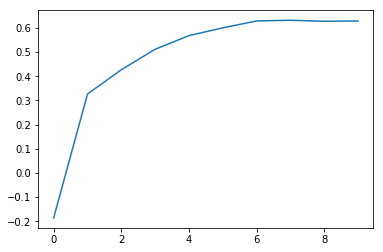

In [28]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [29]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[79.89748951635266, 220.23784263067594, 0.9647498761333972, 0.6856207419235181]


In [30]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[75.69516279239639, 206.8983578016853, 0.9683604254355789, 0.7225504125145532]


In [31]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[77.86619042218754, 216.82077299520753, 0.9665194768411327, 0.6953004778912995, 0.7673996863706095]


In [32]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[76.10001055778348, 214.10706634057192, 0.9680210783767168, 0.7028799236219865, 0.7693889945128484]


In [167]:
df_trn, y_trn, nas = proc_df(df_raw, '15minslater')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [234]:
set_rf_samples(10000)

In [235]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 14.3 s, sys: 4 ms, total: 14.3 s
Wall time: 4.44 s
[178.75987510056368, 232.98888265590045, 0.8235447981960707, 0.6481639036273001, 0.6851315059888172]


In [236]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[165.60128385922874, 219.46164223984363, 0.8485665629992669, 0.6878328167330616, 0.7208618226422585]


In [237]:
reset_rf_samples()

In [164]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [35]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[76.81470705407199, 211.9926061452885, 0.9674175949876065, 0.708719491495392, 0.770450736814238]


In [36]:
t=m.estimators_[0].tree_

In [37]:
dectree_max_depth(t)

49

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[138.11246301394908, 211.73451624723862, 0.894668050774473, 0.7094282973009265, 0.7620419313985499]


In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[119.02111725422503, 205.9327010905361, 0.9217755666363788, 0.7251342495737207, 0.7600645230465625]


In [45]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[76.03667979596621, 199.65936276421667, 0.9680742822263071, 0.7416256734695086, 0.7754404535089003]


In [165]:
# This seems to work most nicely ... tho still 0.744 
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=10, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[76.0697375902325, 205.27636809724933, 0.9680465160683184, 0.7268835198518494, 0.7739012991528404]


In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=25, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[78.25315785114968, 208.9935826418301, 0.9661858772403923, 0.7169025887717551, 0.7747053679701632]


In [49]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=25, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[123.44663215610768, 202.4068742104624, 0.9158502417279, 0.7344657709103172, 0.7698864235642836]


In [247]:
set_plot_sizes(12,14,16)

## Interpretation and improvement

In [122]:
df_raw

index  1_101_N  1_103_N  1_103_S  1_104_N  1_104_S  1_106_N  1_106_S  \
0          0      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1          1    358.0     58.0    426.0    621.0    516.0    531.0    606.0   
2          2    292.0     -8.0    411.0    578.0    501.0    488.0    591.0   
3          3    307.0      7.0    426.0    614.0    516.0    524.0    606.0   
4          4      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5          5    262.0    486.0    426.0    636.0    516.0    546.0    606.0   
6          6    251.0    485.0    411.0    635.0    501.0    545.0    591.0   
7          7    654.0    474.0    411.0    624.0    501.0    534.0    591.0   
8          8    669.0    489.0    426.0    639.0    516.0    549.0    606.0   
9          9    677.0    497.0    426.0    647.0    516.0    557.0    606.0   
10        10    675.0    495.0     69.0    645.0    159.0    555.0    249.0   
11        11    697.0    517.0     50.0    667.0    140.0    423.0    230.0   
12        12    675.0    495.0    906.0    645.0    136.0    444.0    226.0   
13        13    643.0    463.0    906.0    410.0    936.0    440.0    236.0   
14        14    476.0    438.0    894.0    408.0    924.0    438.0    954.0   
15        15    478.0    457.0    906.0    427.0    936.0    457.0    966.0   
16        16    478.0    462.0    906.0    432.0    936.0    462.0    966.0   
17        17    552.0    432.0    891.0    402.0    921.0    432.0    951.0   
18        18    549.0    429.0    894.0    399.0    924.0    429.0    954.0   
19        19    578.0    458.0    906.0    428.0    936.0    563.0    966.0   
20        20    556.0    436.0    906.0    406.0    936.0    547.0    966.0   
21        21    504.0    384.0    891.0    487.0    921.0    517.0    951.0   
22        22    385.0    516.0    906.0    486.0    936.0    516.0    966.0   
23        23    388.0    549.0    909.0    519.0    939.0    549.0    969.0   
24        24    389.0    553.0    906.0    523.0    936.0    553.0    966.0   
25        25    664.0    544.0    906.0    514.0    936.0    544.0    966.0   
26        26    650.0    530.0    906.0    500.0    936.0    530.0    966.0   
27        27    656.0    536.0    932.0    506.0    962.0    536.0    992.0   
28        28    659.0    539.0    935.0    509.0    965.0    578.0    995.0   
29        29    632.0    512.0    906.0    482.0    936.0    557.0    966.0   
...      ...      ...      ...      ...      ...      ...      ...      ...   
40779  43370    491.0    371.0    594.0    491.0    624.0    521.0    654.0   
40780  43371    335.0    446.0    725.0    476.0    605.0    506.0    635.0   
40781  43372    318.0    468.0    725.0    498.0    587.0    528.0    617.0   
40782  43373    644.0    464.0    710.0    494.0    800.0    524.0    593.0   
40783  43374    621.0    441.0    710.0    471.0    800.0    501.0    830.0   
40784  43375    654.0    474.0    725.0    504.0    815.0    534.0    845.0   
40785  43376      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
40786  43377    656.0    476.0    725.0    506.0    815.0    633.0    845.0   
40787  43378    677.0    497.0    724.0     70.0    814.0    640.0    844.0   
40788  43379    631.0    451.0    725.0     74.0    815.0     32.0    845.0   
40789  43380    471.0     62.0    725.0     88.0    815.0    326.0    845.0   
40790  43381    447.0     25.0    725.0     64.0    815.0    327.0    845.0   
40791  43382     43.0     55.0    731.0    290.0    821.0    320.0    851.0   
40792  43383     52.0     51.0    677.0    303.0    767.0    333.0    797.0   
40793  43384     75.0     52.0    665.0    298.0    678.0    328.0    708.0   
40794  43385    171.0     51.0    664.0    295.0    814.0    325.0    730.0   
40795  43386    149.0    160.0    665.0    310.0    815.0    257.0    710.0   
40796  43387    149.0    141.0    665.0    291.0    815.0    245.0    785.0   
40797  43388    177.0    158.0    665.0    208.0    815.0

In [144]:
set_rf_samples(10000)

In [128]:
reset_rf_samples()

In [168]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 3.2 s, sys: 176 ms, total: 3.37 s
Wall time: 3.37 s


(227.15, 116.39234296121029)

In [169]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 168 ms, sys: 232 ms, total: 400 ms
Wall time: 1.95 s


(227.15, 116.39234296121029)

## Feature Importance

In [170]:
fi = rf_feat_importance(m, df_trn); fi[:10]

cols       imp
60          1_133_N  0.042415
64          1_135_N  0.040902
68          1_137_N  0.036199
87  snapshotNYCHour  0.033811
48          1_127_N  0.033448
62          1_134_N  0.033155
46          1_126_N  0.024101
56          1_131_N  0.024042
70          1_138_N  0.023485
5           1_104_S  0.022734

This is pretty cool. It's saying that the biggest determination for the gap time for northbound 1 trains at **23rd St** _in 15 minutes_ is the _current_ value at `1_139_N`, which is **Rector St**, followed by the gap time at **WTC Cortlandt**.

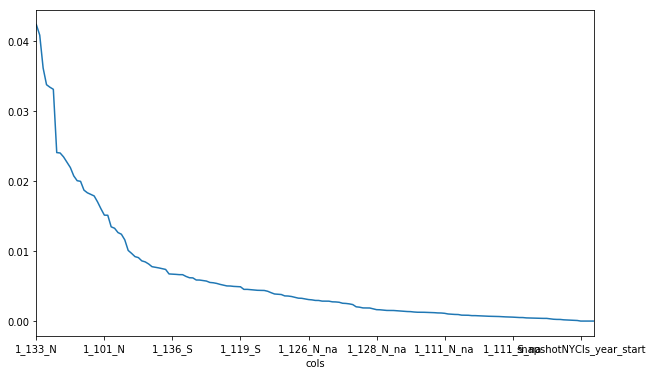

In [171]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [172]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

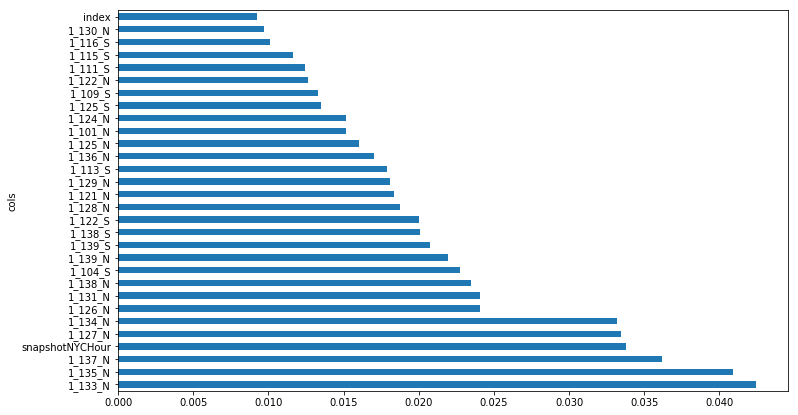

In [173]:
plot_fi(fi[:30]);

In [174]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

58

In [175]:
reset_rf_samples()

In [176]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [180]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=10,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[75.41378217734491, 209.06283522432838, 0.9685952149667018, 0.7167149421005583, 0.7804494857133377]


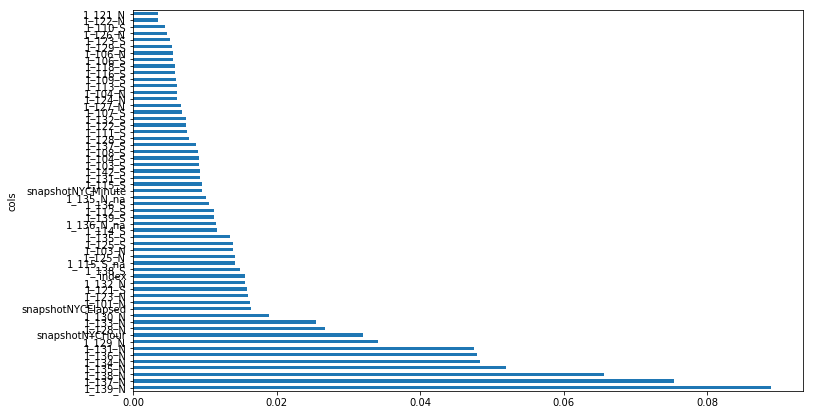

In [181]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [183]:
fi = rf_feat_importance(m, df_keep); fi[:10]

cols       imp
10          1_139_N  0.088935
2           1_137_N  0.075471
8           1_138_N  0.065617
1           1_135_N  0.051997
5           1_134_N  0.048299
18          1_136_N  0.047960
7           1_131_N  0.047504
16          1_129_N  0.034103
3   snapshotNYCHour  0.032010
14          1_128_N  0.026685

In [184]:
from scipy.cluster import hierarchy as hc

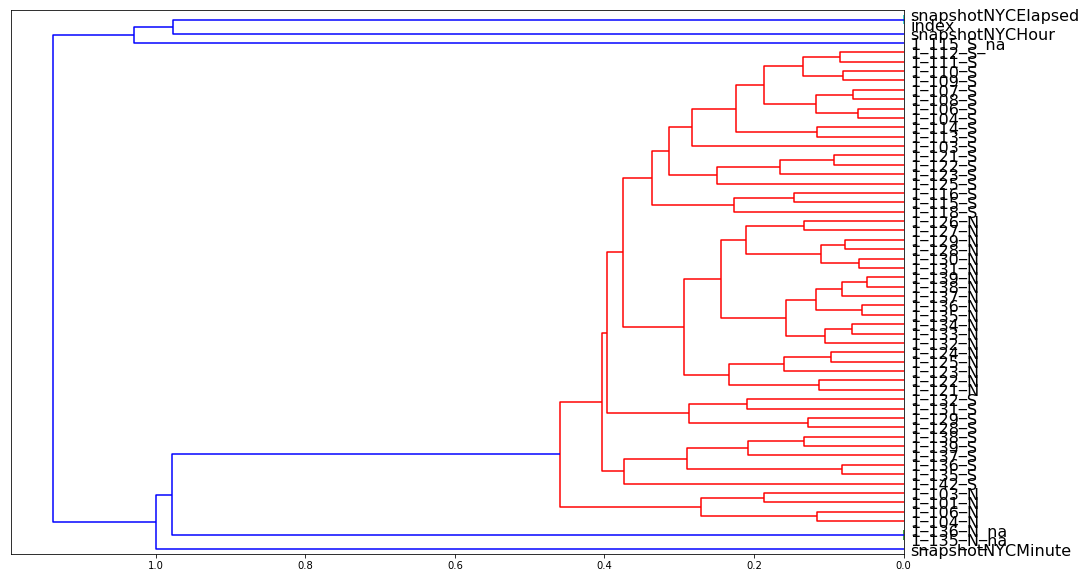

In [185]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [186]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=10, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [187]:
get_oob(df_keep)

0.7892073885496889